## Section 5.2: Ioinising photon production efficiency

In [1]:
from functools import partial
import numpy as np
import h5py
from unyt import Msun, Myr, Angstrom, erg, s, Hz, h
from astropy.cosmology import LambdaCDM
import pandas as pd
from schwimmbad import MultiPool

from synthesizer.grid import Grid
from synthesizer.particle import Galaxy
from synthesizer.instruments.filters import FilterCollection

from synthesizer.emission_models import PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emissions.utils import (
    Ha,
    Hb, 
)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmasher as cmr

from utilities import binned_weighted_quantile, calc_line_corr, calc_line_corr_from_Av

cosmo = LambdaCDM(Om0=0.307, Ode0=0.693, H0=67.77, Ob0=0.04825)
plt.style.use('styles/style.mplstyle')

# Set the random seed for reproducibility
np.random.seed(680010)

In [2]:
def get_data(ii, tag):
    """Helper function to obtain rlevant FLARES data.
    
    Args:
        ii (int): The index of the simulation to load.
        tag (str): The tag of the simulation to load.
        
    Returns:
        tuple: A tuple containing the following arrays:
            - Mstar: Stellar mass of the galaxy.
            - MFUVatt: FUV luminosity after dust attenuation.
            - Halpha: H-alpha luminosity after dust attenuation.
            - Hbeta: H-beta luminosity after dust attenuation.
            - Halphaint: Intrinsic H-alpha luminosity (before dust attenuation).
            - Hbetaint: Intrinsic H-beta luminosity (before dust attenuation).
            - MassweightedZ: Mass-weighted stellar metallicity.
            - ion_ppe: Ionising photon production efficiency.
            - MFUVint: Intrinsic FUV luminosity (before dust attenuation).
            - MFUVstel: Pure stellar FUV luminosity (without nebular emission).
            - Av: V-band attenuation in magnitudes.
            - MassweightedGZ: Mass-weighted gas metallicity.
            - sfr: Star formation rate within a 30 kpc aperture over the last 10 Myr.
    """

    num = str(ii)

    if len(num) == 1:
        num =  '0'+num

    sim = "./data/flares_shared_data.hdf5"
    num = num+'/'

    with h5py.File(sim, 'r') as hf:
        Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
        MassweightedZ = np.array(hf[num+tag+'/Galaxy/Metallicity'].get('CurrentMassWeightedStellarZ'), dtype = np.float32)
        MassweightedGZ = np.array(hf[num+tag+'/Galaxy/Metallicity'].get('MassWeightedGasZ'), dtype = np.float32)
        MFUVatt = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('FUV'), dtype = np.float32) * erg / s / Hz
        MFUVint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('FUV'), dtype = np.float32) * erg / s / Hz
        MFUVstel = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Pure_Stellar'].get('FUV'), dtype = np.float32) * erg / s / Hz

        Av = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('V'), dtype = np.float32) / np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('V'), dtype = np.float32)
        Av = -2.5 * np.log10(Av)

        Halpha = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbeta = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('Luminosity'), dtype = np.float64)
        Halphaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbetaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI4861'].get('Luminosity'), dtype = np.float64)      
        
        ion_ppe = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Indices'].get('IonisingPPE'), dtype = np.float64) 
        
        sfr   = np.array(hf[num+tag+'/Galaxy/SFR_aperture/30'].get('10Myr'), dtype = np.float32)

    ok = (Halphaint>0) * (Mstar>1e8)

    return Mstar[ok], MFUVatt[ok], Halpha[ok], Hbeta[ok], Halphaint[ok], Hbetaint[ok], MassweightedZ[ok], ion_ppe[ok], MFUVint[ok], MFUVstel[ok], Av[ok], MassweightedGZ[ok], sfr[ok]

In [3]:
# Define the synthesizer grid
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps"
grid_dir = "./data/" 
grid = Grid(grid_name, grid_dir=grid_dir)

Zsun = 0.014

Lets see the difference between the ionising photon production rate computed directly from the SED and from H-alpha. This is computed for a constant star formation of 10
Myr for different metallicities. Figure 6 in paper

/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/4217771877.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[ii] = param_stars.photo_lnu['emergent'].photo_lnu
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/4217771877.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  nion[ii] = -np.trapz(y=param_stars.spectra['incident'].lnu[ok] / (h.to('erg*s') * param_stars.spectra['incident'].nu[ok]), x = param_stars.spectra['incident'].nu[ok])
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_2

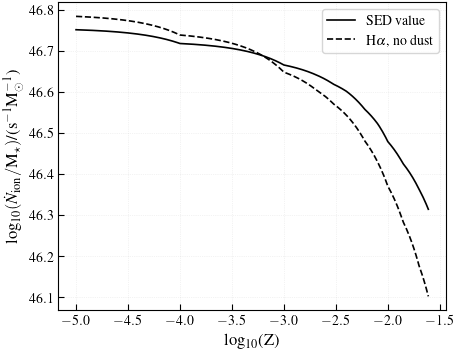

In [4]:
from synthesizer.parametric import SFH, ZDist
from synthesizer.parametric import Stars as ParametricStars

tophats = {
        "UV1500": {"lam_eff": 1500*Angstrom, "lam_fwhm": 300*Angstrom}
    }

filters = FilterCollection(
    tophat_dict=tophats
)
lines = ['H 1 6562.80A']

emodel = PacmanEmission(
            grid=grid,
            tau_v=0,
            dust_curve=PowerLaw()
        )    

Zs = np.arange(-5, -1.6, 0.01)

out = np.zeros(len(Zs))
nion = np.zeros(len(Zs))
ha = np.zeros(len(Zs))

for ii, Z in enumerate(Zs):
    
    # Define the star formation history
    sfh = SFH.Constant(10 * Myr)
    
    # Define the metallicity history
    zh = ZDist.DeltaConstant(metallicity=10**Z)

    # Initialise the parametric Stars object
    param_stars = ParametricStars(
        grid.log10age,
        grid.metallicity,
        sf_hist=sfh,
        metal_dist=zh,
        initial_mass=1 * Msun,
    )
    
    param_stars.get_spectra(emodel)
    param_stars.get_lines(lines, emodel)

    param_stars.get_photo_lnu(filters)

    ok = (grid.lam<=912*Angstrom)    
    out[ii] = param_stars.photo_lnu['emergent'].photo_lnu
    nion[ii] = -np.trapz(y=param_stars.spectra['incident'].lnu[ok] / (h.to('erg*s') * param_stars.spectra['incident'].nu[ok]), x = param_stars.spectra['incident'].nu[ok])
    ha[ii] = param_stars.lines['emergent'].luminosity
    

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 4), sharex=True, sharey=True, facecolor='w', edgecolor='k')
    
ax.plot(Zs, np.log10(nion), label='SED value', color='black')
ax.plot(Zs, np.log10(ha/(1.36e-12)), label=r'H$\alpha$, no dust', color='black', ls='dashed')
ax.legend()
ax.grid(ls='dotted')
ax.set_ylabel(r'log$_{10}(\dot{N}_{\rm ion}/{\rm M}_{\star})$/(s$^{-1}$M$_{\odot}^{-1}$)', fontsize=12)
ax.set_xlabel(r'log$_{10}$(Z)', fontsize=12)

plt.savefig('plots/CSP_10Myr_Ne_Z.png', dpi=300, bbox_inches='tight')
    

In [5]:
# Create required filter collection and lines required for the rest of the notebook
# Define the required lines and their corresponding labels
req_lines = {'H 1 6562.80A': 'Halpha',
             'H 1 4861.32A': 'Hbeta',
             'O 2 3726.03A,O 2 3728.81A': '[OII]3727,29',
             'O 3 4958.91A': '[OIII]4959',
             'O 3 5006.84A': '[OIII]5007',
             'Ne 3 3868.76A': 'NeIII3869'
}

# Define the tophat filters we want to use
tophats = {
    "UV1500": {"lam_eff": 1500*Angstrom, "lam_fwhm": 300*Angstrom},
    "UV2800": {"lam_eff": 2800*Angstrom, "lam_fwhm": 300*Angstrom},
}

filters = FilterCollection(
    filter_codes=['Generic/Johnson.V'],
    tophat_dict=tophats,
    new_lam=grid.lam
)

# Define the lines we want to use
li = [
       Ha,
       Hb, 
   ]

# Wavelengths of the lines we want to use
lam_Ha = 6562.80 * Angstrom
lam_Hb = 4861.32 * Angstrom

### Create toy model galaxies 
(Same across all notebooks)

In [6]:
# Some arbitrary redshift
redshift = 6.

# Number of star particles
n = 100
ages = 10**np.random.uniform(0, np.log10(50), size=n) * Myr
Z = 10**np.random.uniform(-3.5, -2., size=n)
mass = 1e6*np.random.uniform(2, 5, n) * Msun 

# Dust distributions
# We want to explore the impact of varying the dust distribution
# on observed line luminosities and ratios. We do this by drawing
# tau_v values from a normal distribution with mean 0.3 and sigma 0.4,
# and then scaling the sigma by different factors to create different
# dust distributions. We also set a maximum tau_v value of 7 to avoid
# unphysically high values. We also creat 4 different toy galaxies with
# the same average proeprties, but varying first the dust distribution,
# then the age distribution, then the metallicity distribution, and
# finally all properties together.
max_tau = 7
mu, sigma = 0.3, 0.4
nsigma = np.arange(0,max_tau,2)
num_gals = len(nsigma)
colors = cmr.take_cmap_colors('cmr.gem_r', num_gals, return_fmt='rgb')

# Property holders
logOH = np.zeros(4)
lum_int = np.zeros(4, dtype=object)
line_int = np.zeros(4, dtype=object)
sed_int = np.zeros(4, dtype=object)

line_emergent = np.zeros((4, num_gals), dtype=object)
sed_emergent = np.zeros((4, num_gals), dtype=object)
lum_att = np.zeros((4, num_gals))
Av = np.zeros((4, num_gals))
att_curve = np.zeros((4, num_gals, len(grid.lam)))

#Incident and intrinsic
Luv = np.zeros((2, 4))
# Attenuated
Luv_att = np.zeros((4, num_gals))

gal_ippe_Ha = np.zeros((4, num_gals))
nion_Ha = np.zeros((4, num_gals))
Luv_Av = np.zeros((4, num_gals))
gal_ippe_Hb = np.zeros((4, num_gals))
nion_Hb = np.zeros((4, num_gals))
gal_ippe_decrement_Ha = np.zeros((4, num_gals))
nion_decrement_Ha = np.zeros((4, num_gals))
Luv_decrement = np.zeros((4, num_gals))
gal_ippe_decrement_Hb = np.zeros((4, num_gals))
nion_decrement_Hb = np.zeros((4, num_gals))

i_nion_sed = np.zeros(4)
i_nion_Ha = np.zeros(4)
i_nion_Hb = np.zeros(4)
i_ppe_sed = np.zeros(4)
i_ppe_Ha = np.zeros(4)
i_ppe_Hb = np.zeros(4)

# Vary everything
gal = Galaxy(redshift=redshift)
gal.load_stars(
    ages=ages,
    metallicities=Z,
    initial_masses=mass 
)
ok = gal.stars.ages<=10*Myr
Zmean = np.sum(gal.stars.initial_masses[ok] * gal.stars.metallicities[ok]) / np.sum(gal.stars.initial_masses[ok])
Agemean = np.sum(gal.stars.initial_masses[ok] * gal.stars.ages[ok]) / np.sum(gal.stars.initial_masses[ok])

# print (Zmean, Agemean)

# Keep everything fixed
gal_const = Galaxy(redshift=redshift)
gal_const.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary age
gal_vary_age = Galaxy(redshift=redshift)
gal_vary_age.load_stars(
    ages=ages,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary metallicity
gal_vary_Z = Galaxy(redshift=redshift)
gal_vary_Z.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=Z,
    initial_masses=mass 
)

all_gals = [gal_const, gal_vary_age, gal_vary_Z, gal]

tau_v = np.zeros((num_gals, n))
for ii in range(num_gals):
    tmp  = mu + np.random.normal(0, sigma*nsigma[ii], n)
    tmp[tmp<0] = 0.01
    tau_v[ii] = tmp

for jj, kk in enumerate(all_gals):
    # print ("Galaxy number: ", jj)
    ok = kk.stars.ages<=10*Myr
    Zmean = np.sum(kk.stars.initial_masses[ok] * kk.stars.metallicities[ok]) / np.sum(kk.stars.initial_masses[ok])    
    logOH[jj] = 8.69 + np.log10(Zmean/Zsun)

    for ii in range(num_gals):

        emodel = PacmanEmission(
            grid=grid,
            tau_v=tau_v[ii],
            dust_curve=PowerLaw(),
            per_particle=True
        )    
    
    
        kk.stars.get_spectra(emission_model=emodel)    
        kk.stars.get_lines(li,
            emodel
        )           
        
        line_emergent[jj][ii] = kk.stars.lines['emergent']
        
        sed_emergent[jj][ii] = kk.stars.spectra['emergent']
        att_curve[jj][ii] = -2.5 * np.log10(kk.stars.spectra['emergent'].luminosity/kk.stars.spectra['intrinsic'].luminosity)
        kk.stars.spectra['emergent'].get_fnu(cosmo=cosmo, z=redshift)   
        tmp = kk.stars.spectra['emergent'].get_photo_lnu(filters, verbose=False)
        lum_att[jj][ii] = tmp['Generic/Johnson.V']
        Luv_att[jj][ii] = tmp['UV1500']

    line_int[jj] = kk.stars.lines['intrinsic']    
    sed_int[jj] = kk.stars.spectra['intrinsic']
    lum_int[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['Generic/Johnson.V']
    
    Luv[0][jj] = kk.stars.spectra['incident'].get_photo_lnu(filters, verbose=False)['UV1500'] 
    Luv[1][jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['UV1500'] 
    ok = (grid.lam<=912*Angstrom)
    
    i_nion_sed[jj] = -np.trapz(y=kk.stars.spectra['incident'].lnu[ok] / (h.to('erg*s') * kk.stars.spectra['incident'].nu[ok]), x = kk.stars.spectra['incident'].nu[ok])
    i_ppe_sed[jj] = i_nion_sed[jj] / Luv[1][jj]
    
    i_nion_Ha[jj] = line_int[jj]['Ha'].luminosity / 1.36e-12
    i_ppe_Ha[jj] = i_nion_Ha[jj] / Luv[1][jj]
    
    i_nion_Hb[jj] = line_int[jj]['Hb'].luminosity / 4.87e-13 
    i_ppe_Hb[jj] = i_nion_Hb[jj] / Luv[1][jj]

    Av[jj] = -2.5 * np.log10(lum_att[jj]/lum_int[jj])

for jj, kk in enumerate(all_gals):
    for ii in range(num_gals):
        nion_Ha[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, Av[jj][ii], slope=0) / 1.36e-12
        Luv_Av[jj][ii] = calc_line_corr_from_Av(Luv_att[jj][ii], 1500*Angstrom, Av[jj][ii], slope=0)

        nion_Hb[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Hb'].luminosity, lam_Hb, Av[jj][ii], slope=0) / 4.87e-13
        
        nion_decrement_Ha[jj][ii] = calc_line_corr(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, line_emergent[jj][ii]['Ha'].luminosity/line_emergent[jj][ii]['Hb'].luminosity) / 1.36e-12
        Luv_decrement[jj][ii] = calc_line_corr(Luv_att[jj][ii], 1500*Angstrom, line_emergent[jj][ii]['Ha'].luminosity/line_emergent[jj][ii]['Hb'].luminosity)

        nion_decrement_Hb[jj][ii] = calc_line_corr(line_emergent[jj][ii]['Hb'].luminosity, lam_Hb, line_emergent[jj][ii]['Ha'].luminosity/line_emergent[jj][ii]['Hb'].luminosity) / 4.87e-13

gal_ippe_Ha = nion_Ha / Luv_Av
gal_ippe_Hb = nion_Hb / Luv_Av
gal_ippe_decrement_Ha = nion_decrement_Ha / Luv_decrement
gal_ippe_decrement_Hb = nion_decrement_Hb / Luv_decrement

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3529924751.py:63: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3529924751.py:76: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_const.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3529924751.py:84: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_vary_age.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3529924751.py:92: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_vary_Z.load_stars(
/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
/var/folders/j_/zbbc0z3n0f1c3fncxt

#### Plot the ionising photon production efficiency of the toy model galaxies

This is Figure 7 in paper

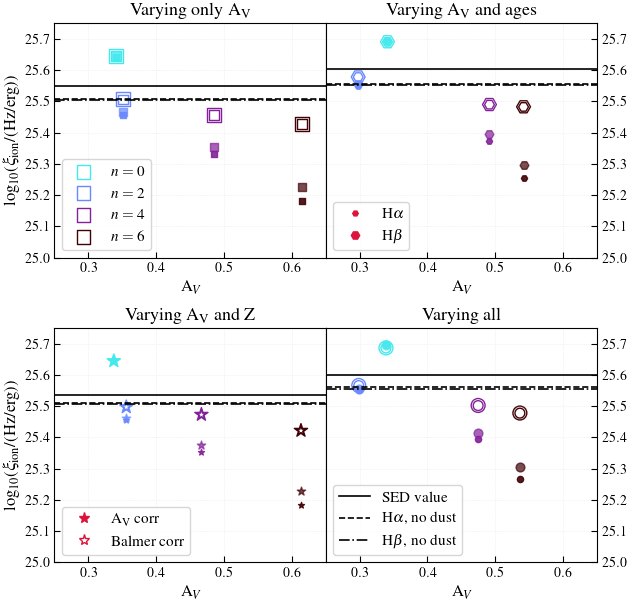

In [7]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(7, 7), facecolor='w', edgecolor='k')
axs = axs.ravel()

stitle = [r'Varying only A$_{\mathrm{V}}$', r'Varying A$_{\mathrm{V}}$ and ages', r'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']

markers = ['s', 'H', '*', 'o']
custom_att = [Line2D([], [], marker='*', markersize=8, color='crimson', linestyle='None', markerfacecolor=ii) for ii in ['crimson', 'None']]

custom_line = [Line2D([], [], marker='H', markersize=ii, color='crimson', linestyle='None') for ii in [4, 6]]

for jj, ax in enumerate(axs):
    if jj==3:
        ax.axhline(y=np.log10(i_ppe_sed[jj]), label='SED value', color='black')
        ax.axhline(y=np.log10(i_ppe_Ha[jj]), label=r'H${\alpha}$, no dust', color='black', ls='dashed')
        ax.axhline(y=np.log10(i_ppe_Hb[jj]), label=r'H${\beta}$, no dust', color='black', ls='dashdot')
    else:
        ax.axhline(y=np.log10(i_ppe_sed[jj]), color='black')
        ax.axhline(y=np.log10(i_ppe_Ha[jj]), color='black', ls='dashed')
        ax.axhline(y=np.log10(i_ppe_Hb[jj]), color='black', ls='dashdot')

    for ii in range(num_gals):
        color = colors[ii]     
        
        ax.scatter(Av[jj][ii], np.log10(gal_ippe_Ha[jj][ii]), color=color, s=20, marker=markers[jj], alpha=0.9)
            
        ax.scatter(Av[jj][ii], np.log10(gal_ippe_Hb[jj][ii]), color=color, s=40, marker=markers[jj], alpha=0.7)
        
        ax.scatter(Av[jj][ii], np.log10(gal_ippe_decrement_Ha[jj][ii]), edgecolor=color, facecolor='None', s=50, marker=markers[jj])
        
        if jj==0:
            ax.scatter(Av[jj][ii], np.log10(gal_ippe_decrement_Hb[jj][ii]), edgecolor=color, facecolor='None', s=100, marker=markers[jj], label=rF'$n={nsigma[ii]}$')
        else:
            ax.scatter(Av[jj][ii], np.log10(gal_ippe_decrement_Hb[jj][ii]), edgecolor=color, facecolor='None', s=100, marker=markers[jj])
        
    ax.grid(ls='dotted')
    ax.set_xlabel(r'A$_{V}$', fontsize=12)
    ax.set_xlim(0.25, 0.65)
    ax.set_ylim(25., 25.75)
    ax.set_title(stitle[jj], fontsize=13)

    
axs[1].yaxis.tick_right()
axs[3].yaxis.tick_right()

axs[0].set_ylabel(r'log$_{10}$($\xi_{\rm ion}$/(Hz/erg))', fontsize=12)
axs[2].set_ylabel(r'log$_{10}$($\xi_{\rm ion}$/(Hz/erg))', fontsize=12)

axs[0].legend(frameon=True, fontsize=11, loc='lower left') 
axs[1].legend(custom_line, [r'H${\rm \alpha}$', r'H${\rm \beta}$'], frameon=True, fontsize=11, loc='lower left')
axs[2].legend(custom_att, [r'A$_{\rm V}$ corr', r'Balmer corr'], frameon=True, fontsize=11, loc='lower left')
axs[3].legend(frameon=True, fontsize=11, loc='lower left') 

fig.subplots_adjust(hspace=0.3, wspace=0)
plt.savefig('plots/toy_ion_ppe.png', dpi=300, bbox_inches='tight')
plt.show()   


#### Plot the ionising photon production rate of the toy model galaxies

Exploratory plot

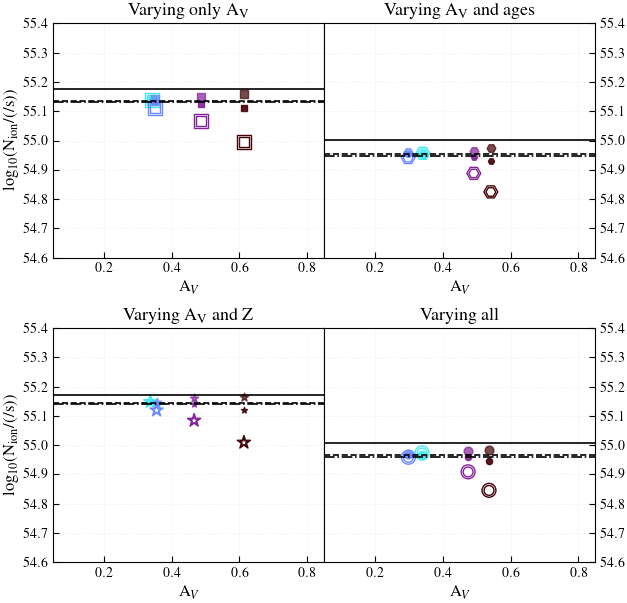

In [8]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(7, 7), facecolor='w', edgecolor='k')
axs = axs.ravel()

stitle = [r'Varying only A$_{\mathrm{V}}$', r'Varying A$_{\mathrm{V}}$ and ages', r'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']

for jj, ax in enumerate(axs):
    
    if jj==3:
        ax.axhline(y=np.log10(i_nion_sed[jj]), label='SED value', color='black')
        ax.axhline(y=np.log10(i_nion_Ha[jj]), label=r'H${\alpha}$, no dust', color='black', ls='dashed')
        ax.axhline(y=np.log10(i_nion_Hb[jj]), label=r'H${\beta}$, no dust', color='black', ls='dashdot')
    else:
        ax.axhline(y=np.log10(i_nion_sed[jj]), color='black')
        ax.axhline(y=np.log10(i_nion_Ha[jj]), color='black', ls='dashed')
        ax.axhline(y=np.log10(i_nion_Hb[jj]), color='black', ls='dashdot')

    for ii in range(num_gals):
        color = colors[ii]        
        
        ax.scatter(Av[jj][ii], np.log10(nion_Ha[jj][ii]), color=color, s=20, marker=markers[jj], alpha=0.9)
            
        ax.scatter(Av[jj][ii], np.log10(nion_Hb[jj][ii]), color=color, s=40, marker=markers[jj], alpha=0.7)
        
        ax.scatter(Av[jj][ii], np.log10(nion_decrement_Ha[jj][ii]), edgecolor=color, facecolor='None', s=50, marker=markers[jj])
        
        if jj==0:
            ax.scatter(Av[jj][ii], np.log10(nion_decrement_Hb[jj][ii]), edgecolor=color, facecolor='None', s=100, marker=markers[jj], label=rF'$\sigma={nsigma[ii]}$')
        else:
            ax.scatter(Av[jj][ii], np.log10(nion_decrement_Hb[jj][ii]), edgecolor=color, facecolor='None', s=100, marker=markers[jj])
        
    ax.grid(ls='dotted')
    ax.set_xlabel(r'A$_{V}$', fontsize=12)
    ax.set_xlim(0.05, 0.85)
    ax.set_ylim(54.6, 55.4)
    ax.set_title(stitle[jj], fontsize=13)

axs[1].yaxis.tick_right()
axs[3].yaxis.tick_right()
axs[0].set_ylabel(r'log$_{10}$(N$_{\rm ion}$/(/s))', fontsize=12)
axs[2].set_ylabel(r'log$_{10}$(N$_{\rm ion}$/(/s))', fontsize=12)

fig.subplots_adjust(hspace=0.3, wspace=0)
plt.show()   

#### Plot the UV-luminosities of the toy model galaxies

Exploratory plot

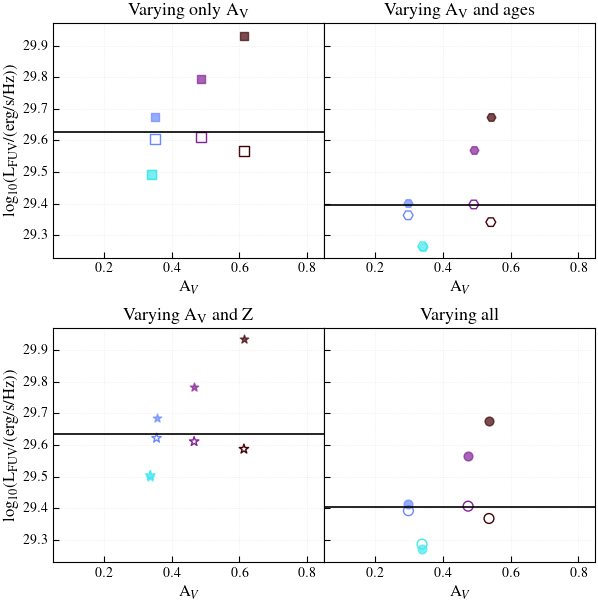

In [9]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(7, 7), facecolor='w', edgecolor='k', sharex=False, sharey=True)
axs = axs.ravel()

stitle = [r'Varying only A$_{\mathrm{V}}$', r'Varying A$_{\mathrm{V}}$ and ages', r'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']

for jj, ax in enumerate(axs):
    
    ax.axhline(y=np.log10(Luv[1][jj]), color='black')

    for ii in range(num_gals):
        color = colors[ii]
        
        ax.scatter(Av[jj][ii], np.log10(Luv_Av[jj][ii]), color=color, s=40, marker=markers[jj], alpha=0.7)
        
            
        ax.scatter(Av[jj][ii], np.log10(Luv_decrement[jj][ii]), edgecolor=color, facecolor='None', s=50, marker=markers[jj])
        
    ax.grid(ls='dotted')
    ax.set_xlabel(r'A$_{V}$', fontsize=12)
    ax.set_xlim(0.05, 0.85)
    # ax.set_ylim(24.6, 25.45)
    ax.set_title(stitle[jj], fontsize=13)
    
        
axs[2].set_xlabel(r'A$_{V}$', fontsize=12)
axs[3].set_xlabel(r'A$_{V}$', fontsize=12)
axs[0].set_ylabel(r'log$_{10}$(L$_{\rm FUV}$/(erg/s/Hz))', fontsize=12)
axs[2].set_ylabel(r'log$_{10}$(L$_{\rm FUV}$/(erg/s/Hz))', fontsize=12)

fig.subplots_adjust(hspace=0.3, wspace=0.)
plt.show()   

### Deriving the ionising photon produciton efficiencies of the FLARES galaxies
Dust correct H-alpha and H-beta using the Balmer decrement and Av

In [10]:
quantiles = [0.84,0.50,0.16]
Muv_limit = -19.
df = pd.read_csv('./data/weights_grid.txt')
weights = np.array(df['weights'])

tags = ['010_z005p000', '009_z006p000', '008_z007p000', '007_z008p000', '006_z009p000', '005_z010p000']

quantiles = [0.023,0.50,0.977]
mbins = np.arange(8,11.2,0.5)
mbincen = (mbins[1:] + mbins[:-1])/2.
yy, yy_low, yy_up = np.zeros((6, 7, len(mbincen))), np.zeros((6, 7, len(mbincen))), np.zeros((6, 7, len(mbincen)))

MZ = {}
mstar = {}
flares_ha_nodust = {}
flares_ha_dustcorr = {}
flares_ha_dustbalcorr = {}
flares_hb_nodust = {}
flares_hb_dustcorr = {}
flares_hb_dustbalcorr = {}
Avs = {}
sfrs = {}

for ii, tag in enumerate(tags):
    z = float(tag[5:].replace('p','.'))
    print ("z: ", z)

    func    = partial(get_data, tag=tag)
    pool    = MultiPool(processes=4)
    dat     = np.array(list(pool.map(func, np.arange(0,40))), dtype='object')
    pool.close()

    Mstar = np.log10(np.concatenate(dat[:,0]))
    MFUVatt = np.concatenate(dat[:,1])
    Halpha = np.concatenate(dat[:,2])
    Hbeta = np.concatenate(dat[:,3])
    Halphaint = np.concatenate(dat[:,4])
    Hbetaint = np.concatenate(dat[:,5])
    MassweightedZ = np.concatenate(dat[:,6])
    ion_ppe = np.concatenate(dat[:,7])
    MFUVint = np.concatenate(dat[:,8])
    MFUVstel = np.concatenate(dat[:,9])
    Av = np.concatenate(dat[:,10])
    MassweightedGZ = np.concatenate(dat[:,11])
    sfr = np.concatenate(dat[:,12])
    
    MZ[tag] = MassweightedZ
    mstar[tag] = Mstar
    Avs[tag] = Av
    sfrs[tag] = sfr

    ion_ppe = MFUVstel.to('erg/s/Hz') * ion_ppe / MFUVint.to('erg/s/Hz')

    tot_gals = len(Mstar)

    ws = np.zeros(tot_gals)
    n = 0
    for jj in range(40):
        if jj==0:
            ws[0:len(dat[jj][0])] = weights[jj]
        else:
            ws[n:n+len(dat[jj][0])] = weights[jj]

        n+=len(dat[jj][0])

    flares_ha_nodust[tag] = (Halphaint) / (1.36e-12 * MFUVint.to('erg/s/Hz').to_value())

    flares_ha_dustcorr[tag] = calc_line_corr_from_Av(Halpha * erg/s, lam_Ha, Av, slope=0).to_value() / (1.36e-12 * calc_line_corr_from_Av(MFUVatt.to('erg/s/Hz'), 1500*Angstrom, Av, slope=0).to_value())

    flares_ha_dustbalcorr[tag] = calc_line_corr(Halpha * erg/s, lam_Ha, Halpha/Hbeta).to_value() / (1.36e-12 * calc_line_corr(MFUVatt.to('erg/s/Hz'), 1500*Angstrom, Halpha/Hbeta).to_value())

    flares_hb_nodust[tag] = (Hbetaint) / (4.87e-13 * MFUVint.to('erg/s/Hz').to_value()) 
    flares_hb_dustcorr[tag] = calc_line_corr_from_Av(Hbeta * erg/s, lam_Hb, Av, slope=0).to_value() / (4.87e-13 * calc_line_corr_from_Av(MFUVatt.to('erg/s/Hz'), 1500*Angstrom, Av, slope=0).to_value())

    flares_hb_dustbalcorr[tag] = calc_line_corr(Hbeta * erg/s, lam_Hb, Halpha/Hbeta).to_value() / (4.87e-13 * calc_line_corr(MFUVatt.to('erg/s/Hz'), 1500*Angstrom, Halpha/Hbeta).to_value())

    tmp = binned_weighted_quantile(Mstar, np.log10(ion_ppe), ws, mbins, quantiles)
    yy[ii][0], yy_low[ii][0], yy_up[ii][0] = tmp[:,1], tmp[:,0], tmp[:,2]

    tmp = binned_weighted_quantile(Mstar, np.log10(flares_ha_nodust[tag]), ws, mbins, quantiles)
    yy[ii][1], yy_low[ii][1], yy_up[ii][1] = tmp[:,1], tmp[:,0], tmp[:,2]

    tmp = binned_weighted_quantile(Mstar, np.log10(flares_ha_dustcorr[tag]), ws, mbins, quantiles)
    yy[ii][2], yy_low[ii][2], yy_up[ii][2] = tmp[:,1], tmp[:,0], tmp[:,2]

    tmp = binned_weighted_quantile(Mstar, np.log10(flares_ha_dustbalcorr[tag]), ws, mbins, quantiles)
    yy[ii][3], yy_low[ii][3], yy_up[ii][3] = tmp[:,1], tmp[:,0], tmp[:,2]

    tmp = binned_weighted_quantile(Mstar, np.log10(flares_hb_nodust[tag]), ws, mbins, quantiles)
    yy[ii][4], yy_low[ii][4], yy_up[ii][4] = tmp[:,1], tmp[:,0], tmp[:,2]

    tmp = binned_weighted_quantile(Mstar, np.log10(flares_hb_dustcorr[tag]), ws, mbins, quantiles)
    yy[ii][5], yy_low[ii][5], yy_up[ii][5] = tmp[:,1], tmp[:,0], tmp[:,2]

    tmp = binned_weighted_quantile(Mstar, np.log10(flares_hb_dustbalcorr[tag]), ws, mbins, quantiles)
    yy[ii][6], yy_low[ii][6], yy_up[ii][6] = tmp[:,1], tmp[:,0], tmp[:,2]

z:  5.0


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3993157805.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3993157805.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

z:  6.0


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3993157805.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3993157805.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

z:  7.0


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3993157805.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3993157805.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

z:  8.0


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3993157805.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3993157805.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

z:  9.0


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3993157805.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3993157805.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

z:  10.0


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3993157805.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3993157805.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

#### Plot the ionising photon production efficiency for z=6 FLARES galaxies

Figure 8 in paper

<>:68: SyntaxWarning: invalid escape sequence '\s'
<>:69: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:68: SyntaxWarning: invalid escape sequence '\s'
<>:69: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\s'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3432022214.py:68: SyntaxWarning: invalid escape sequence '\s'
  axs[3].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=16)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3432022214.py:69: SyntaxWarning: invalid escape sequence '\s'
  axs[4].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=16)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_26122/3432022214.py:70: SyntaxWarning: invalid escape sequence '\s'
  axs[5].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=16)


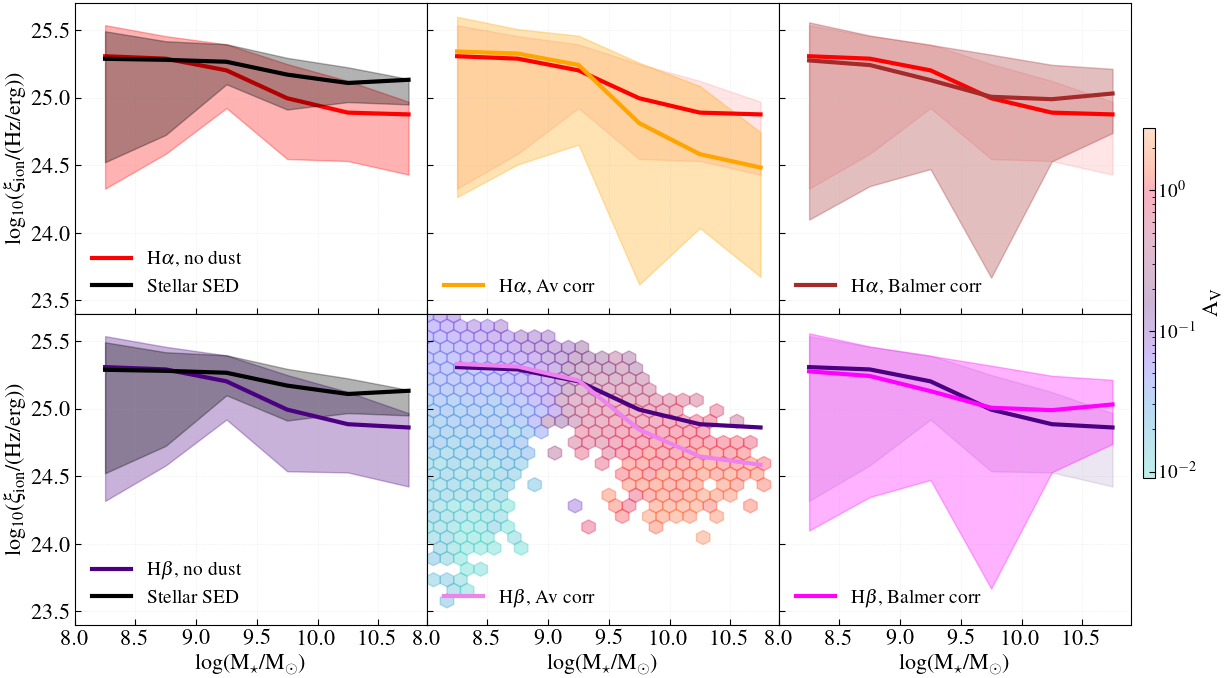

In [11]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 7), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs=axs.ravel()

labels = ['Stellar SED', r'H$\alpha$, no dust', r'H$\alpha$, Av corr', r'H$\alpha$, Balmer corr', r'H$\beta$, no dust', r'H$\beta$, Av corr', r'H$\beta$, Balmer corr']

colors = ['black', 'red', 'orange', 'brown', 'indigo', 'violet', 'magenta']
c_m = plt.get_cmap('cmr.guppy_r')
xlims = (8, 11)
ylims = (23.5, 26)
xgrid, ygrid = 0.11, 0.15

gridsize = np.array([(int(max(xlims)-min(xlims))/xgrid), int((max(ylims)-min(ylims))/ygrid)]).astype(int)
z = sfrs[tags[1]]
z = (z - min(z)) / (max(z) - min(z))

hb = axs[4].hexbin(mstar[tags[1]], np.log10(flares_hb_dustcorr[tags[1]]), bins='log', gridsize=gridsize, extent=[*xlims,*ylims], alpha = 0.3, C = Avs[tags[1]], reduce_C_function = np.median, cmap = c_m, mincnt = 2, vmin=0.009, vmax=max(Avs[tags[1]]), zorder=0)


for jj in range(3):
    if jj==0:        
             
        axs[jj].plot(mbincen, yy[1][1], label=labels[1], color=colors[1], lw=3)       
        axs[jj+3].plot(mbincen, yy[1][4], label=labels[4], color=colors[4], lw=3)
        
        axs[jj].fill_between(mbincen, yy_low[1][1], yy_up[1][1], color=colors[1], alpha=0.3)
        axs[jj+3].fill_between(mbincen, yy_low[1][4], yy_up[1][4], color=colors[4], alpha=0.3)
                
    else:
        axs[jj].plot(mbincen, yy[1][1], color=colors[1], lw=3)
        axs[jj+3].plot(mbincen, yy[1][4], color=colors[4], lw=3)   
        
        axs[jj].fill_between(mbincen, yy_low[1][1], yy_up[1][1], color=colors[1], alpha=0.1)
        if jj+3!=4:
            axs[jj+3].fill_between(mbincen, yy_low[1][4], yy_up[1][4], color=colors[4], alpha=0.1)

axs[0].plot(mbincen, yy[1][0], label=labels[0], color=colors[0], lw=3)
axs[0].fill_between(mbincen, yy_low[1][0], yy_up[1][0], color=colors[0], alpha=0.3, zorder=15)

axs[1].plot(mbincen, yy[1][2], label=labels[2], color=colors[2], lw=3)
axs[1].fill_between(mbincen, yy_low[1][2], yy_up[1][2], color=colors[2], alpha=0.3)

axs[2].plot(mbincen, yy[1][3], label=labels[3], color=colors[3], lw=3)
axs[2].fill_between(mbincen, yy_low[1][3], yy_up[1][3], color=colors[3], alpha=0.3)

axs[3].plot(mbincen, yy[1][0], label=labels[0], color=colors[0], lw=3)
axs[3].fill_between(mbincen, yy_low[1][0], yy_up[1][0], color=colors[0], alpha=0.3)

axs[4].plot(mbincen, yy[1][5], label=labels[5], color=colors[5], lw=3)
# axs[4].fill_between(mbincen, yy_low[1][5], yy_up[1][5], color=colors[5], alpha=0.3)

axs[5].plot(mbincen, yy[1][6], label=labels[6], color=colors[6], lw=3)
axs[5].fill_between(mbincen, yy_low[1][6], yy_up[1][6], color=colors[6], alpha=0.3)



for jj in range(6):
    
    axs[jj].legend(fontsize=14, frameon=False, loc='lower left')
    axs[jj].grid()
    axs[jj].set_xlim(8, 10.9)
    axs[jj].set_ylim(23.4, 25.7)
    for label in (axs[jj].get_xticklabels() + axs[jj].get_yticklabels()):
        label.set_fontsize(16)
    
axs[0].set_ylabel(r'log$_{10}$($\xi_{\rm ion}$/(Hz/erg))', fontsize=16)  
axs[3].set_ylabel(r'log$_{10}$($\xi_{\rm ion}$/(Hz/erg))', fontsize=16)    
    
axs[3].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=16)
axs[4].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=16)
axs[5].set_xlabel('log(M$_{\star}$/M$_{\odot}$)', fontsize=16)
    
fig.tight_layout()
cbaxes = fig.add_axes([0.99, 0.3, 0.01, 0.5])
fig.colorbar(hb, cax=cbaxes)
fig.subplots_adjust(bottom=0.09, left = 0.1, right=0.98, wspace=0, hspace=0)

cbaxes.set_ylabel(r'A$_{\rm V}$', fontsize=16)
cbaxes.yaxis.set_label_position("right")
for label in cbaxes.get_yticklabels():
    label.set_fontsize(14)
plt.savefig('plots/ion_ppe.png', dpi=300, bbox_inches='tight')

#### Plot the redshift evolution of the ionising photon production efficiency
We split the galaxies into different mass bins

Figure 9 in paper

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


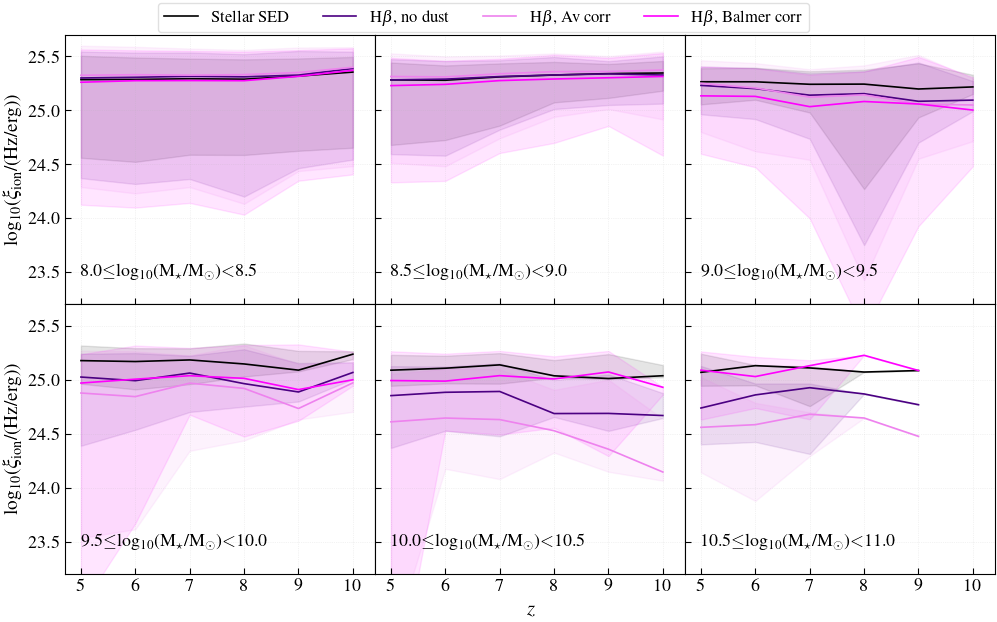

In [12]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 7), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs=axs.ravel()

ax_title = []
labels = ['Stellar SED', r'H$\alpha$, no dust', r'H$\alpha$, Av corr', r'H$\alpha$, Balmer corr', r'H$\beta$, no dust', r'H$\beta$, Av corr', r'H$\beta$, Balmer corr']

colors = ['black', 'red', 'orange', 'brown', 'indigo', 'violet', 'magenta']
zs = np.arange(5, 11, 1)

for jj in range(6):
    for ii in [0,4,5,6]:
        
        tmp_y = yy[:,:,jj][:,ii]
        tmp_yup = yy_up[:,:,jj][:,ii]
        tmp_ylow = yy_low[:,:,jj][:,ii]
        
        ok = np.isfinite(tmp_y) * np.isfinite(tmp_yup) * np.isfinite(tmp_ylow)
        
        if jj==0:
            axs[jj].plot(zs[ok], tmp_y[ok], color=colors[ii], label=labels[ii])
        else:
            axs[jj].plot(zs[ok], tmp_y[ok], color=colors[ii])
            
        axs[jj].fill_between(zs[ok], tmp_ylow[ok], tmp_yup[ok], color=colors[ii], alpha=0.1)
    
    axs[jj].legend(fontsize=12, frameon=False)
    axs[jj].grid()
    axs[jj].set_xlim(4.7, 10.4)
    axs[jj].set_ylim(23.2, 25.7)

axs[0].legend(frameon=True, fontsize=12, ncols=4, loc=(0.3,1.01), framealpha=0.6)
    
axs[0].set_ylabel(r'log$_{10}$($\xi_{\rm ion}$/(Hz/erg))', fontsize=14)   
axs[3].set_ylabel(r'log$_{10}$($\xi_{\rm ion}$/(Hz/erg))', fontsize=14)   
axs[4].set_xlabel('$z$', fontsize=15)

for ii, ax in enumerate(axs):
    ax.text(5., 23.5, F'{mbins[ii]}'+r'$\leq$log$_{10}$(M$_{\star}$/M$_{\odot}$)$<$'+F'{mbins[ii+1]}', va='center', fontsize=13)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(13)
    
fig.subplots_adjust(hspace=0,wspace=0)
plt.savefig('plots/ion_ppe_z_evo.png', dpi=300, bbox_inches='tight')